# Inverse Hankel transform and the Ogata method

In [1]:
import numpy as np
import sympy as sp
import pylab as py
#from  matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text',usetex=True)
%matplotlib inline
import vegas
from scipy.special import jv, jn_zeros, yv
import scipy.special as spec
from scipy.optimize import fsolve
from scipy.optimize import fmin
from scipy.integrate import quad
from scipy.optimize import fsolve
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from inverters import AdOg
from scipy.interpolate import spline
import warnings
warnings.filterwarnings('ignore')

## gamma distribution function as prototype function in bT space

In [2]:
def Wtilde(bT,Q,sigma):
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return bT**(a-1)*np.exp(-bT/b)/b**a/spec.gamma(a)

def W(qT, Q, sigma, nu):
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return 1/(2*np.pi)*spec.gamma(a+nu)/spec.gamma(a)*(b*qT/2.0)**nu*spec.hyp2f1((a+nu)/2.0, (a+nu+1.0)/2.0, nu+1.0, -qT**2.0*b**2.0)/spec.gamma(nu+1.0)

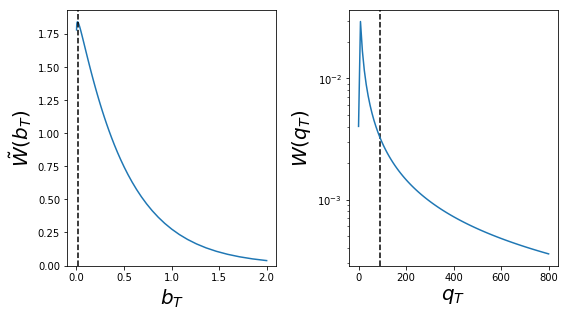

In [3]:
def update(Q=90,sigma=2,bTmax=10,qTmax=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    ax=py.subplot(121)
    bT=10**np.linspace(-3,np.log10(bTmax),100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,ls='--',color='k')
    ax.set_ylim(0,None)
    #ax.semilogx()

    
    
    ax=py.subplot(122)
    qT=np.linspace(1e-1,qTmax,100)    
    ax.axvline(Q,ls='--',color='k')
    ax.plot(qT,W(qT,Q,sigma,nu))
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    #ax.set_ylim(0,None)
    ax.semilogy()
    
    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(0,2,1),qTmax=(0,1000,1));

## numerical inversion using quadrature method

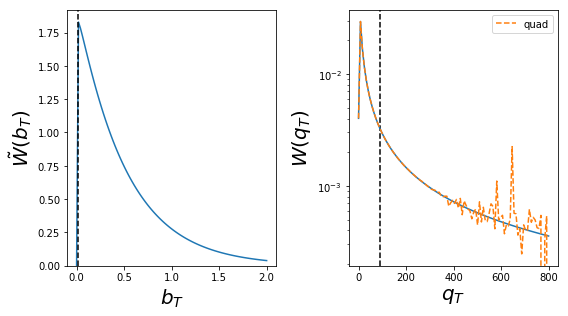

In [4]:
def Quadinversion1(w, q, nu):
    return 1/(2*np.pi)*quad(lambda bT: jv(nu,q*bT)*w(bT),0,np.inf)[0]

def update(Q=90,sigma=2,bTmax=10,qTmax=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    ax=py.subplot(121)
    bT=np.linspace(0,bTmax,100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,color='k',ls='--')
    ax.set_ylim(0,None)

    ax=py.subplot(122)    
    qT=np.linspace(1e-1,qTmax,100)    
    ax.axvline(Q,ls='--',color='k')
    ax.plot(qT,W(qT,Q,sigma,nu))
    ax.plot(qT,[Quadinversion1(lambda bT: Wtilde(bT,Q,sigma), q, nu) for q in qT],label='quad',ls='--')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()

    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(0,2,1),qTmax=(0,1000,1));

## numerical inversion using MC method

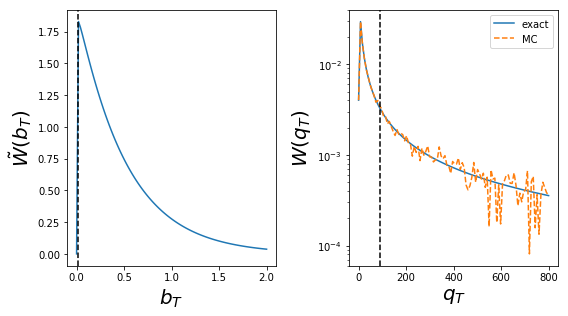

In [5]:
def transform(f, p):
    return f(np.tan(p))*(1/np.cos(p))**2
integ = vegas.Integrator([[0, np.pi/2.0]])

def MCinversion(f, q, nu, m):
    return 1/(2*np.pi)*float(str(integ(lambda p: transform(f, p)*jv(nu, q*np.tan(p)), nitn=10, neval=m)[0]).split('+-')[0].split('(')[0])

def update(Q=90,sigma=2,bTmax=10,qTmax=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    ax=py.subplot(121)
    bT=np.linspace(0,bTmax,100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,ls='--',color='k')


    ax=py.subplot(122)    
    qT=np.linspace(1e-1,qTmax,100)
    ax.plot(qT,W(qT,Q,sigma,nu),label='exact')
    ax.plot(qT,[MCinversion(lambda bT: Wtilde(bT,Q,sigma), q, nu, 400) for q in qT],label='MC',ls='--')
    ax.axvline(Q,ls='--',color='k')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()


    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(0,2,1),qTmax=(0,1000,1));

In [6]:
def ogata(f,h,N, nu):
    zeros=jn_zeros(nu,N)
    xi=zeros/np.pi
    Jp1=jv(nu+1,np.pi*xi)
    w=yv(nu, np.pi * xi) / Jp1
    get_psi=lambda t: t*np.tanh(np.pi/2*np.sinh(t))
    get_psip=lambda t:np.pi*t*(-np.tanh(np.pi*np.sinh(t)/2)**2 + 1)*np.cosh(t)/2 + np.tanh(np.pi*np.sinh(t)/2)
    knots=np.pi/h*get_psi(h*xi)
    Jnu=jv(nu,knots)
    psip=get_psip(h*xi)
    F=f(knots)
    return np.pi*np.sum(w*F*Jnu*psip)

def get_ogata_params(w, xmin, xmax, qT, nu):
    zero1 = jn_zeros(nu, 1)[0]
    h = fsolve(lambda h: xmin-zero1*np.tanh(np.pi/2*np.sinh(h/np.pi*zero1)), xmin)[0]
    k = fsolve(lambda k: xmax-np.pi*k*np.tanh(np.pi/2*np.sinh(h*k)), xmax)[0]
    N = int(k)
    return h,k,N

def Ogatainversion(w, xmin, xmax, qT, nu):
    h,k,N=get_ogata_params(w, xmin, xmax, qT, nu)
    return 1/(2*np.pi)*ogata(lambda x: w(x/qT)/qT,h,N, nu)

def update(Q=90,sigma=2,qTmax=900,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))
    
    ax=py.subplot(121)
    bT=np.linspace(0,10,100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,ls='--',color='k')

    ax=py.subplot(122)
    qT=np.linspace(1e-1,qTmax,100)
    ax.plot(qT,W(qT,Q,sigma,nu),label='exact')
    xmin=lambda q: 1e-5*q#mean*q/500
    xmax=lambda q: 20*q#mean*q*100
    ax.plot(qT,[Ogatainversion(lambda bT: Wtilde(bT,Q,sigma),xmin(q),xmax(q),q,nu) for q in qT],label='ogata',ls='--')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()

    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),nu=(0,2,1),qTmax=(0,1000,1));

interactive(children=(FloatSlider(value=90.0, description=u'Q', max=200.0), FloatSlider(value=2.0, description=u'sigma', max=10.0, step=0.01), IntSlider(value=900, description=u'qTmax', max=1000), IntSlider(value=1, description=u'nu', max=2), Output()), _dom_classes=('widget-interact',))

In [7]:
ADOG = AdOg()
def update(Q=90,sigma=2,qTmax=900,nu=1,Nmax=10):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))
    
    ax=py.subplot(121)
    bT=np.linspace(0,10,100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,ls='--',color='k')

    ax=py.subplot(122)
    qT=np.linspace(100,qTmax,100)
    ax.plot(qT,W(qT,Q,sigma,nu),label='exact')
    vals=[ADOG.adog(lambda bT: Wtilde(bT,Q,sigma), q, nu, Nmax, Q) for q in qT]
    ax.plot(qT,vals,label='ogata',ls='--')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()

    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),nu=(0,2,1),qTmax=(0,1000,1),Nmax=(10,200,10));

interactive(children=(FloatSlider(value=90.0, description=u'Q', max=200.0), FloatSlider(value=2.0, description=u'sigma', max=10.0, step=0.01), IntSlider(value=900, description=u'qTmax', max=1000), IntSlider(value=1, description=u'nu', max=2), IntSlider(value=10, description=u'Nmax', max=200, min=10, step=10), Output()), _dom_classes=('widget-interact',))

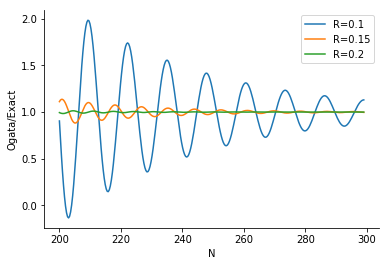

In [72]:
exact = lambda l: l/(1.0+l**2)**(1.5)
nlist = [i for i in range(200,300)]
nnew = np.linspace(nlist[0],nlist[-1],300)
vals025=[ogata(lambda b: b*np.exp(-0.05*b),0.1/n,n, 0)/exact(0.05) for n in nlist]
smooth025 = spline(nlist,vals025,nnew)
vals05 =[ogata(lambda b: b*np.exp(-0.05*b),0.15/n,n, 0)/exact(0.05) for n in nlist]
smooth05 = spline(nlist,vals05,nnew)
vals1 = [ogata(lambda b: b*np.exp(-0.05*b),0.2/n,n, 0)/exact(0.05) for n in nlist]
smooth1 = spline(nlist,vals1,nnew)
fig = py.figure(figsize=(6, 4))
ax=py.subplot(111)
ax.plot(nnew,smooth025,label=r"R=0.1")
ax.plot(nnew,smooth05,label=r"R=0.15")
ax.plot(nnew,smooth1,label=r"R=0.2")
ax.set_xlabel("N")
ax.set_ylabel("Ogata/Exact")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.legend()
py.savefig('Rconvergence.pdf')
py.show()

In [ ]:
hlist = [1.0/i for i in range(10,50)]
vals025=[1/2.0/np.pi*ogata(lambda b: Wtilde(b,10.0,1.0),h,int(0.3/h), 0)/W(1.0, 10.0, 1.0, 0) for h in hlist]
vals05 = [1/2.0/np.pi*ogata(lambda b: Wtilde(b,10.0,1.0),h,int(0.5/h), 0)/W(1.0, 10.0, 1.0, 0) for h in hlist]
vals1 = [1/2.0/np.pi*ogata(lambda b: Wtilde(b,10.0,1.0),h,int(1.0/h), 0)/W(1.0, 10.0, 1.0, 0) for h in hlist]
space = [1/h for h in hlist]
ax=py.subplot(111)
ax.plot(space,vals025,label="0.25")
#ax.plot(space,vals05,label="0.5")
#ax.plot(space,vals1,label="1.0")
ax.legend()
py.show()

In [ ]:
ADOG = AdOg()
def update(Q=90,sigma=2,qTmax=900,nu=1,eps=0.5):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))
    
    ax=py.subplot(121)
    bT=np.linspace(0,10,100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,ls='--',color='k')

    ax=py.subplot(122)
    qT=np.linspace(1e-1,qTmax,100)
    ax.plot(qT,W(qT,Q,sigma,nu),label='exact')
    vals=[ADOG.adog2(lambda bT: Wtilde(bT,Q,sigma),q,nu,Q,epsilon=eps) for q in qT]
    ax.plot(qT,vals,label='ogata',ls='--')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()

    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),nu=(0,2,1),qTmax=(0,1000,1),eps=(0.01,0.5,0.05));

# numerical inversion using Ogata method

## test the relation between x, xi, h and N

In [ ]:
def update(h=0.1,N=10,nu=1):
    ncols,nrows=1,1
    fig = py.figure(figsize=(ncols*5,nrows*4))

    xnots=jn_zeros(nu,N)*np.tanh(np.pi/2*np.sinh(h/np.pi*jn_zeros(nu,N)))
    xi=jn_zeros(nu,N)/np.pi
        
    ax=py.subplot(111)
    ax.plot(xi,xnots,'o')
    ax.set_xlabel(r'$\xi_k$',size=20)
    ax.set_ylabel(r'$x_k$',size=20)

    py.tight_layout()    
    py.show()
interact(update,h=(0.01,1,0.01),N=(0,100,1),nu=(0,2,1));

## test sampling region for a given qT

In [ ]:
def update(Q=90,sigma=2,qT=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    f=lambda x: 1/(2*np.pi*qT)*Wtilde(x/qT,Q,sigma)
    
    xmin=1e-10*qT
    xmax=10*qT
    zero1 = jn_zeros(nu, 1)[0]
    h = fsolve(lambda h: xmin-zero1/qT*np.tanh(np.pi/2*np.sinh(h/np.pi*zero1)), xmin)[0]
    k = fsolve(lambda k: xmax-np.pi*k/qT*np.tanh(np.pi/2*np.sinh(h*k)), xmax)[0]
    N = int(k)
    #print N
    #h=1
    #N=1000
    xnots=jn_zeros(nu,N)*np.tanh(np.pi/2*np.sinh(h/np.pi*jn_zeros(nu,N)))
    x=10**np.linspace(np.log10(xmin),np.log10(xmax),10000)
    
    ax=py.subplot(121)
    #ax.axvline(1/Q,color='k',ls='--')
    ax.plot(xnots,f(xnots),'r.')
    ax.plot(x,f(x))
    ax.set_ylim(0,None)
    ax.semilogx()

    ax=py.subplot(122)
    ax.plot(xnots,f(xnots)*jv(nu+1,np.pi*xnots),'r.')    
    ax.plot(x,f(x)*jv(nu+1,np.pi*x))

    #x=10**np.linspace(np.log10(xmin),np.log10(xmax),10000)
    #ax.set_ylim(0,None)
    ax.semilogx()

    
    #ax.semilogx()
    
    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(1,3,1),qT=(0,1000,1));